# Bike Sharing Demand Step 4

---
### Analysis summary and modeling strategy
#### 1) Analysis summary
1. Transform target values
- before training : 'count' > log(count)
- after training : log(count) > 'count'
2. Add derived features
- 'year', 'month', 'day', 'hour', 'minute', 'second'
- 'weekday'
3. Remove features
- 'casual', 'registered'
- 'datetime'
- 'date', 'month'
- 'day', 'minute', 'second'
- 'windspeed'
4. Delete outliers
- Data whose 'weather' value is 4

#### 2) Modeling strategy
- Baseline model : LinearRegression
- Performance improvement : Ridge, Lasso, RandomForest
    + Feature engineering : Same apply for each model
    + Hyperparameter optimization : GridSearch
- Etc
    + Target value is log(count) not count
--- 

## 4. Performance improvement
- Process
    1. Import data
    2. Feature engineering
    3. Make evaluation metrics calculation function
    4. Hyperparameter optimization (Train model)
        + **Generate model**
        + **Generate GridSearch object**
        + **Train GridSearch**
    5. Validate performance
        + If performance is not good, go back to **Feature Engineering** or **Hyperparameter Optimization**
    6. Submit

### 4.1. Ridge Regression Model
- Regularization : The way to ensure that a model does not overfit the training data
- Ridge regression model : Linear regression model which apply L2 regularization
    + alpha : Parameter that adjust the degree of regularization

#### 1) Import data

In [1]:
# Import data
import pandas as pd

data_path = '../../Datasets/bike_sharing_demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

#### 2) Feature engineering

In [2]:
# Delete outliers of train data
train = train[train['weather'] != 4]

# Merge train data and test data
all_data = pd.concat([train, test], ignore_index=True)

# Add derived features
from datetime import datetime
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateStr: datetime.strptime(dateStr, "%Y-%m-%d").weekday())

# Remove unnecessary features
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']
all_data = all_data.drop(drop_features, axis=1)

# Split data into train data and test data
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# Remove target values from train and test data
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

# Target values
y = train['count']

#### 3) Make evaluation index calculation function

In [3]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # Exponential transformation
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Log transformation and convert missing values to zero    
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # Calculate RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

#### 4) Hyperparameter optimization (Train model)
- GridSearch finds **optimal hyperparameter values** by changing hyperparameter values and evaluating model performance through cross-validation


- Process
    1. Generate model
    2. Generate GridSearch object
        + Target model
        + List of hyperparameter values (Dictionary type)
        + Evaluation function for cross-validation
    3. Train model (GridSearch)

##### (1) Generate model

In [4]:
# Generate model
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

##### (2) Generate GridSearch object
- Preparations
    + Target model
    + List of hyperparameter values (Dictionary type)
    + Evaluation function for cross-validation
- GridSearchCV() parameters
    + **estimator** : Classification/regression model
    + **param_grid** : Dictionary of hyperparameter name and hyperparameter values
    + **scoring** : Evaluation metrics
        - accracy, f1, roc_auc, recall are basically provided
        - metrics.make_scorer : The function used when creating a separate evaluation metrics
    + **cv** : Number of cross-validation splits

In [5]:
# List of hyperparameter values (Dictionary type)
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# Evaluation function for cross-validation (RMSLE score)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

In [6]:
# Generate GridSearch object (with Ridge)
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                     param_grid=ridge_params,
                                     scoring=rmsle_scorer,
                                     cv=5)

##### (3) Train model (GridSearch)
- Store the best performing value in **best_params_** attribute
- Store the best model trained with the optimal values in **best_estimator_** attribute

In [7]:
# Log transformation of target values
log_y = np.log(y)

# Train model and GridSearch
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [8]:
print('best hyperparameter :', gridsearch_ridge_model.best_params_)

best hyperparameter : {'alpha': 0.1, 'max_iter': 3000}


#### 5) Validate performance

In [9]:
# Predict with train data
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# Evaluate Lasso model
print(f'RMSLE value of Ridge model : {rmsle(log_y, preds, True):.4f}')

RMSLE value of Ridge model : 1.0205


### 4.2. Lasso Regression Model
- Lasso regression model : Linear regression model which apply L1 regularization
    + alpha : Parameter that adjust the degree of regularization

#### 4) Hyperparameter optimization (Train model)
- Process
    1. Generate model
    2. Generate GridSearch object
        + Target model
        + List of hyperparameter values (Dictionary type)
        + Evaluation function for cross-validation
    3. Train model (GridSearch)

In [10]:
# Generate model
from sklearn.linear_model import Lasso
lasso_model = Lasso()

# List of hyperparameter values (Dictionary type)
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

# Generate GridSearch object (with Lasso)
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                     param_grid=lasso_params,
                                     scoring=rmsle_scorer,
                                     cv=5)

# Train model (GridSearch)
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('best hyperparameter :', gridsearch_lasso_model.best_params_)

best hyperparameter : {'alpha': 0.00125, 'max_iter': 3000}


#### 5) Validate performance

In [11]:
# Predict with train data
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# Evaluate Lasso model
print(f'RMSLE value of Lasso model : {rmsle(log_y, preds, True):.4f}')

RMSLE value of Lasso model : 1.0205


### 4.3. Random Forest Regression Model
- Random Forest regression model : A regression model combining decision trees by bagging
    + n_estimators : The number of decision trees to compose a random forest

#### 4) Hyperparameter optimization (Train model)
- Process
    1. Generate model
    2. Generate GridSearch object
        + Target model
        + List of [hyperparameter](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor) values (Dictionary type)
        + Evaluation function for cross-validation
    3. Train model (GridSearch)

In [12]:
# Generate model
from sklearn.ensemble import RandomForestRegressor
randomforest_model = RandomForestRegressor()

# List of hyperparameter values (Dictionary type)
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}

# Generate GridSearch object (with RandomForest)
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

# Train model (GridSearch)
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('best parameter :', gridsearch_random_forest_model.best_params_)

best parameter : {'n_estimators': 140, 'random_state': 42}


#### 5) Validate performance

In [13]:
# Predict with train data
preds = gridsearch_random_forest_model.predict(X_train)

# Evaluate Lasso model
print(f'RMLSE value of Random Forest regression model : {rmsle(log_y, preds, True):.4f}')

RMLSE value of Random Forest regression model : 0.1127


#### 6) Submit
- If the distributions of the training and test data are similar, the overfitting problem is relatively small
- So if the model performance is good on the training data, it is likely to be good on the test data as well

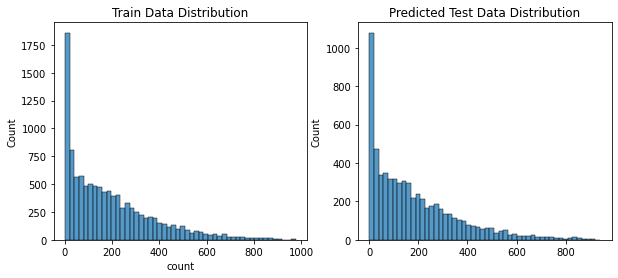

In [14]:
# Distributions of target values of train data and test data
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [15]:
# Exponential transformation
submission['count'] = np.exp(randomforest_preds)

# Save submission file
submission.to_csv('submission.csv', index=False)

References
===
- [EDA reference](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
- [Modeling reference](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)
- 머신러닝.딥러닝 문제해결 전략(신백균)